In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import random
import copy

from collections import Counter, defaultdict
from deap import base, creator, tools
from tqdm import tqdm

In [2]:
threshold = 0.2
egoradius = 2
attr_name = 'gender'

# AMARE - Attribute-aware MARginalization Estimator

In [3]:
g = nx.Graph()
g.name = 'copenhagen'
with open('bt_symmetric.csv') as f:
    for l in f.readlines()[1:]:
        tid, a, b, rssi = l.rstrip().split(',')
        g.add_edge(int(a),int(b), tid=tid)
print('loaded net')

attrs = {n: None for n in g.nodes()} # also fix missing data
with open('genders.csv') as f:
    for l in f.readlines()[1:]:
        node, gender = l.rstrip().split(',')
        attrs[int(node)] = gender
    nx.set_node_attributes(g, attrs, name=attr_name)
print('loaded attributes')

to_remove = []
for n in attrs:
    if attrs[n] is None:
        to_remove.append(n)

g.remove_nodes_from(to_remove)
print('unlabeled removed')

loaded net
loaded attributes
unlabeled removed


In [4]:
print(nx.info(g))

Name: copenhagen
Type: Graph
Number of nodes: 673
Number of edges: 75124
Average degree: 223.2511


In [5]:
attrs = nx.get_node_attributes(g, attr_name)

In [6]:
#g = nx.convert_node_labels_to_integers(g)
sizes = dict(Counter(list(attrs.values())))
sizes['0'] = sizes['0'] / (len(g))
sizes['1'] = sizes['1'] / (len(g))
weights = dict(Counter(list(attrs.values())))
weights['0'] = 1 - sizes['0']
weights['1'] = 1 - sizes['1']

In [7]:
marg_dict = dict()

for node in tqdm(g.nodes()):
    attr = attrs[node]
    
    # COMPUTE MARGINALIZATION
    marg = 0
    egonet = list(g.neighbors(node)) + [node]
    egonet_attrs = [attrs[n] for n in egonet]
    
    count = dict(Counter(egonet_attrs))[attr]
    size = len(egonet_attrs)
    
    if size > 2:
        marg = ((count * weights[attr] / (count * weights[attr] + (size-count)* (1 - weights[attr]))) - 0.5) * 2
    else:
        marg = 0
    
    marg_dict[node] = marg

disc_nodes = [k for k,v in marg_dict.items() if abs(v) > threshold]
disc = len(disc_nodes)

100%|██████████| 673/673 [00:00<00:00, 12229.46it/s]


In [8]:
plausible = nx.Graph() # stores plausible links

for node in tqdm(disc_nodes):
    egonet = list(g.neighbors(node)) + [node]
    egonet2 = nx.ego_graph(g, node, center=True, radius=egoradius)
    egonet2.remove_nodes_from(egonet)
    for n in egonet2.nodes():
        if node != n and n in disc_nodes:
            if marg_dict[node] > 0:
                if attrs[n] != attrs[node]:
                    plausible.add_edge(node, n)
            elif marg_dict[node] < 0:
                if attrs[n] == attrs[node]:
                    plausible.add_edge(node, n)         
            else:
                print("ERROR")
                
links = list(plausible.edges())

100%|██████████| 103/103 [00:47<00:00,  2.19it/s]


=== STATS ===
Marginalized nodes: 103
Global Discrimination: 15.304606240713225
Overall Marginalization Score: 0.1129377217024731


<AxesSubplot:ylabel='Density'>

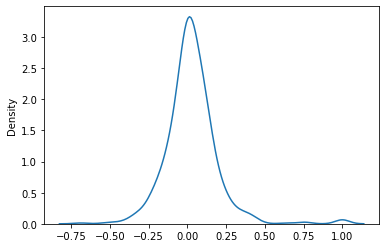

In [9]:
print("=== STATS ===")
print("Marginalized nodes:", disc)
print("Global Discrimination:", disc * 100 / len(g.nodes()))
print("Overall Marginalization Score:", np.mean([abs(x) for x in marg_dict.values()]))
sns.kdeplot(list(marg_dict.values()))

# MARK - MArginalization Reducer using linK

In [10]:
def random_individual(links):
    individual = []
    for e in links:
        individual.append(random.randint(0,1))
    return individual 

In [11]:
def evaluate(individual, g):
    individual = individual[0] #<- because DEAP
    score = 0
    eva_g = copy.deepcopy(g)
    indexes = [i for i, j in enumerate(individual) if j == 1]
    new_links = [links[i] for i in indexes]

    for l in new_links:
        eva_g.add_edge(l[0], l[1])
            
    for node in disc_nodes:
        marg = 0
        egonet = list(eva_g.neighbors(node)) + [node]
        egonet_attrs = [attrs[n] for n in egonet]
        count = dict(Counter(egonet_attrs))[attr]
        size = len(egonet)
        if size > 2:
            marg = ((count * weights[attr] / (count * weights[attr] + (size-count)* (1 - weights[attr]))) - 0.5) * 2
            if abs(marg) > threshold:
                score += 1
        
    budget = sum(individual)
            
    return score, budget

    #Fitness 1: nodi marginalizzati rimasti
    #Fitness 2: link usati
    
    #A parità di nodi marginalizzati (il meno possibile), la soluzione con meno link usati è la migliore

In [12]:
creator.create("Fitness", base.Fitness, weights=(-1.0,-1.0)) # <- -1 perché vogliamo minimizzare la fitness
creator.create("Individual", list, fitness=creator.Fitness) #<- l'individuo è definito come lista

toolbox = base.Toolbox() #creiamo il toolbox

toolbox.register("random_individual", random_individual, links) 
#"nome_della_funzione per deap", nome_della_funzione vera e propria di python, parametri che passi alla funzione

toolbox.register("individual", tools.initRepeat, creator.Individual, 
                 toolbox.random_individual, n=1) 
# n = numero di individui nella popolazione. Lasciamo 1

toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate, g=g) #funzione di valutazione. Vedi quanto detto sopra
toolbox.register("mate", tools.cxTwoPoint) #funzione di crossover
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05) #funzione di mutazione custom
toolbox.register("select", tools.selTournament, tournsize=3)
#tools.selNSGA2) #funzione di selezione

Marginalized nodes: 103 · Available links: 3037
gen	nevals	min	avg  
0  	150   	45 	51.22
1  	93    	45 	49.58
2  	91    	45 	48.7933
3  	99    	42 	47.6533
4  	91    	42 	46.88  
5  	96    	42 	46.12  
6  	97    	41 	45.1   
7  	104   	39 	44.5533
8  	96    	40 	43.9   
9  	92    	39 	43.1333
10 	92    	38 	42.8133
11 	98    	38 	42.3067
12 	98    	37 	41.9333
13 	102   	37 	41.44  
14 	82    	37 	40.86  
15 	93    	36 	40.0267
16 	96    	36 	40.1   
17 	94    	36 	39.4   
18 	88    	35 	38.8667
19 	94    	35 	38.0667
20 	95    	35 	38.0533
21 	91    	34 	37.6067
22 	88    	34 	37.4267
23 	99    	34 	37.1467
24 	90    	34 	37.04  
25 	96    	34 	36.64  
26 	100   	34 	35.9333
27 	91    	34 	36     
28 	91    	34 	35.8667
29 	86    	34 	35.8067
30 	104   	34 	35.7867
31 	94    	34 	35.5933
32 	103   	33 	35.5   
33 	85    	33 	35.3933
34 	100   	33 	35.32  
35 	92    	33 	35.3533
36 	93    	33 	35.2867
37 	78    	33 	34.7133
38 	85    	33 	34.7067
39 	98    	32 	34.44  
40 	95    	32 	

<Figure size 432x288 with 0 Axes>

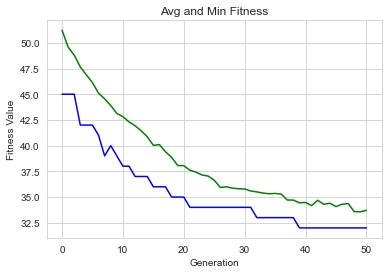

In [13]:
print('Marginalized nodes:', disc, '· Available links:', len(links))
NUM_GENERATIONS = 50 #numero di generazioni
POPULATION_SIZE = 150 #popolazione per gen

CXPB, MUTPB = 0.5, 0.25 #crossover e mutation probability

n_HOF = 10 #top soluzioni da ritornare (la "Hall of Fame" di DEAP è il set di tutte le top n soluzioni)

pop = toolbox.population(n=POPULATION_SIZE)

hof = tools.HallOfFame(n_HOF)

stats = tools.Statistics(lambda ind: ind.fitness.values[0])   
stats.register('min', np.min, axis = 0)
stats.register('avg', np.mean, axis = 0)

logbook = tools.Logbook()
logbook.header = ['gen', 'nevals'] + stats.fields

invalid_individuals = [ind for ind in pop if not ind.fitness.valid]
fitnesses = toolbox.map(toolbox.evaluate, invalid_individuals)
for ind, fit in zip(invalid_individuals, fitnesses):
    ind.fitness.values = fit

hof.update(pop)
hof_size = len(hof.items)

record = stats.compile(pop)
logbook.record(gen=0, best="-", nevals=len(invalid_individuals), **record)
print(logbook.stream)

for gen in range(1, NUM_GENERATIONS + 1):

            # Select the next generation individuals
    offspring = toolbox.select(pop, len(pop))
    # Clone the selected individuals
    offspring = list(map(toolbox.clone, offspring))


    # Apply crossover and mutation on the offspring
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < CXPB:
            toolbox.mate(child1[0], child2[0])
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:
        if random.random() < MUTPB:
            toolbox.mutate(mutant[0])
            del mutant.fitness.values


    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # Update the hall of fame with the generated individuals
    hof.update(offspring)

    # Replace the current population by the offspring
    pop[:] = offspring

    # Append the current generation statistics to the logbook
    record = stats.compile(pop) if stats else {}
    logbook.record(gen=gen, nevals=len(invalid_ind), **record)
    print(logbook.stream)


hof.update(pop) # la HoF è aggiornata con la nuova popolazione (o meglio, i suoi individui migliori w.r.t. fitness)

plt.figure(1)

minFitnessValues, meanFitnessValues = logbook.select("min", "avg")
plt.figure(2)
sns.set_style("whitegrid")
#plt.plot(maxFitnessValues, color='red')
plt.plot(minFitnessValues, color='blue')
plt.plot(meanFitnessValues, color='green')
plt.xlabel('Generation')
plt.ylabel('Fitness Value')
plt.title('Avg and Min Fitness')
# show both plots:
plt.show()


#return hof.items

In [14]:
for e in hof.items:
    print('Marginalized nodes:', e.fitness.values[0], '· Links:', e.fitness.values[1])
    print(e[0])
    print()

Marginalized nodes: 32.0 · Links: 1478.0
[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0

In [15]:
best = hof.items[0][0]

index = [i for i, j in enumerate(best) if j == 1]

new_links = [links[i] for i in index]

new_links

[(7, 8),
 (7, 24),
 (7, 27),
 (7, 83),
 (7, 125),
 (7, 200),
 (7, 213),
 (7, 230),
 (7, 266),
 (7, 319),
 (7, 374),
 (7, 419),
 (7, 440),
 (7, 450),
 (7, 590),
 (7, 400),
 (7, 332),
 (7, 478),
 (7, 498),
 (7, 436),
 (7, 510),
 (7, 198),
 (7, 161),
 (7, 77),
 (7, 124),
 (7, 644),
 (7, 479),
 (8, 32),
 (8, 36),
 (8, 146),
 (8, 274),
 (8, 443),
 (8, 589),
 (8, 600),
 (8, 546),
 (8, 625),
 (8, 94),
 (8, 261),
 (8, 287),
 (8, 426),
 (8, 440),
 (8, 487),
 (8, 518),
 (8, 332),
 (8, 510),
 (8, 658),
 (8, 496),
 (8, 644),
 (8, 479),
 (8, 38),
 (24, 32),
 (24, 36),
 (24, 41),
 (24, 112),
 (24, 174),
 (24, 196),
 (24, 211),
 (24, 218),
 (24, 293),
 (24, 296),
 (24, 550),
 (24, 562),
 (24, 589),
 (24, 645),
 (24, 355),
 (24, 622),
 (24, 33),
 (24, 76),
 (24, 94),
 (24, 83),
 (24, 266),
 (24, 287),
 (24, 374),
 (24, 396),
 (24, 426),
 (24, 463),
 (24, 487),
 (24, 518),
 (24, 400),
 (24, 510),
 (24, 198),
 (24, 161),
 (24, 124),
 (24, 658),
 (24, 644),
 (24, 392),
 (24, 695),
 (27, 266),
 (27, 319),

Random Benchmark

In [26]:
rans = []
c = 0
print("Marginalized nodes:", end = ' ')
while c < 100:
    ran = random_individual(links)
    print(evaluate([ran], g)[0], end = ' ')
    rans.append(evaluate([ran], g)[0])
    c = c+1
print()
print()
print("Avg:", np.mean(rans), "· Min:", min(rans))

Marginalized nodes: 13 19 18 14 18 16 17 16 19 14 18 18 20 20 17 16 18 20 17 20 14 15 18 16 14 19 20 18 19 19 16 19 14 18 14 18 18 15 17 19 18 18 18 19 17 19 17 18 17 17 19 19 17 16 20 17 14 14 18 18 17 21 19 17 15 16 16 19 17 15 18 15 15 18 14 14 15 16 19 19 15 14 19 19 16 15 20 17 17 20 17 14 16 17 17 18 16 19 20 17 

Avg: 17.16 · Min: 13
